<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=0
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_arhuaco_esp_completo_1_3B"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="arh_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/arh_completo.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="arh"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(5785, 2)
Index(['arh', 'esp'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4628 entries, 339 to 860
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     4628 non-null   object
 1   esp     4628 non-null   object
dtypes: object(2)
memory usage: 108.5+ KB


In [9]:
df_train.head()

,arh,esp
339,"Padán-arám ayekʉ pari ʉnnakʉn nu'kwe'ri, mazak...","Cuando yo regresaba de Parán Aram, se me murió..."
837,"i'ngwi uga mowga kʉtow ʉnhakwʉya nariri, i'ngw...","éramos doce hermanos, hijos del mismo padre; u..."
4222,Awi krususe' asakayri: ʻEmari judíw zʉ rey gu...,"—Si tú eres el rey de los judíos, sálvate a ti..."
387,Ey uye' nʉngwari “posuri Sebá za'kinukʉngwa ni...,"Isaac le puso el nombre de Sebá —es decir, «Ju..."
4381,Ey ʉweri kʉtʉkʉnʉn ka'gʉmʉ a'bore pari profeta...,De este modo demuestran estar de acuerdo con l...


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 578 entries, 2201 to 457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     578 non-null    object
 1   esp     577 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


In [11]:
df_dev.head()

,arh,esp
2201,Altarzey nari ga'kʉnamʉ mikʉnchunhʉnʉngwa ni y...,"¡Ciegos! ¿Qué es más importante, la ofrenda o ..."
2225,Awi nʉngwari winʉkʉriwiya ɉinari ɉiwʉ chukutar...,Cuando los discípulos llegaron a la otra orill...
1652,"Josese'ri: —“Máykʉnʉ kúkwʉri, máykʉnʉ ɉwía, za...",José le dijo:—Esta es la interpretación: los t...
354,Iwa mari migwia ɉina gwasi umʉn me'kawiri ka'g...,"Y a ti, te doy una franja de tierra mayor que ..."
2518,Jesuse'ri:—“Nʉpaw kinkiri chiwa powru Israeri ...,Jesús entonces dijo:—Dios me ha enviado solame...


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 3303 to 2299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   arh     579 non-null    object
 1   esp     579 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [13]:
df_test.head()

,arh,esp
3303,Uye'ki Jesuse' yow winʉkʉkariri: —“Ʉɉway ikʉ s...,Entonces Jesús los reunió y les dijo:—Como muy...
2715,á ka'mʉkanʉya ɉinari: —“Eymari Juan Bautista e...,y comentó con sus cortesanos:—Este es Juan el ...
1897,Ey uye' nʉngwa reyri i'ngweygwi gunamʉ winga's...,"Volvió a enviarles más criados, con este encar..."
2389,"Ʉwe'ki miwiri, inʉ achwʉn, awiri ey kʉno'kwʉn ...","En cuanto a ustedes, felices sus ojos por lo q..."
179,"Ka'se' inu a'chuiakumuyeykazey nari,jwi anni'k...",regalias


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,arh,arh_words,arh_toks
4022,—Un sembrador salió a sembrar su semilla. Al l...,"[—, Un, sembrador, salió, a, sembrar, su, semi...","[▁, —, Un, ▁sembr, ador, ▁salió, ▁a, ▁sem, bra...",—“I'ngwi ʉnkʉniga keywʉ zaɉuna ʉnzarikʉn zoyan...,"[—, “, I, ', ngwi, ʉnkʉniga, keywʉ, zaɉuna, ʉn...","[▁, —“, I, ', ng, wi, ▁, ʉ, nk, ʉ, niga, ▁key,..."
3174,Pilato le preguntó:—¿Eres tú el rey de los jud...,"[Pilato, le, preguntó, :, —, ¿, Eres, tú, el, ...","[▁Pilato, ▁le, ▁pregunt, ó, :, —, ¿, E, res, ▁...",Ey awi Pilatuse'ri: —“¿Má ki judíw ɉina zʉ rey...,"[Ey, awi, Pilatuse, ', ri, :, —, “, ¿, Má, ki,...","[▁Ey, ▁awi, ▁Pilat, use, ', ri, :, ▁, —“, ¿, M..."
1329,"Los hijos de Elifaz fueron: Temán, Omar, Sefó,...","[Los, hijos, de, Elifaz, fueron, :, Temán, ,, ...","[▁Los, ▁hijos, ▁de, ▁Eli, fa, z, ▁fueron, :, ▁...","Awi nʉngwa Elifa zʉ gʉmʉsinʉ ɉinari: Temán, Om...","[Awi, nʉngwa, Elifa, zʉ, gʉmʉsinʉ, ɉinari, :, ...","[▁Awi, ▁n, ʉ, ngwa, ▁Eli, fa, ▁z, ʉ, ▁g, ʉ, m,..."
1590,Y bendijo Dios el día séptimo y lo declaró día...,"[Y, bendijo, Dios, el, día, séptimo, y, lo, de...","[▁Y, ▁bendi, jo, ▁Dios, ▁el, ▁día, ▁sé, p, tim...","Ey awi Niwipawri koga ɉwíndi ʉnka'guka awiri, ...","[Ey, awi, Niwipawri, koga, ɉwíndi, ʉnka, ', gu...","[▁Ey, ▁awi, ▁Ni, wi, paw, ri, ▁koga, ▁, ɉ, w, ..."
5016,"Ya Moisés dijo al respecto: El Señor, el Dios ...","[Ya, Moisés, dijo, al, respecto, :, El, Señor,...","[▁Ya, ▁Moisés, ▁dijo, ▁al, ▁respecto, :, ▁El, ...",ey ʉwaki eyma profeta a'no'ku' neykari powruse...,"[ey, ʉwaki, eyma, profeta, a, ', no, ', ku, ',...","[▁ey, ▁, ʉ, waki, ▁ey, ma, ▁profeta, ▁a, ', no..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_245897/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,arh_toks,esp_words,arh_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.769700,70.777700,26.177200,36.199700
std,15.782825,32.307254,12.679293,17.633959
min,1.000000,2.000000,1.000000,1.000000
25%,23.000000,49.000000,18.000000,25.000000
50%,31.000000,67.000000,25.000000,34.000000
75%,40.000000,88.000000,32.000000,45.000000
max,438.000000,730.000000,330.000000,494.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.2518412970065553
1.9552012861985042


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/5785 [00:00<?, ?it/s]

4376


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

["Ey awi niwisinamʉ ʉnnika awiri mibu'gʉmʉ ɉinari niwisin kʉsanika unige'ri, niwibu'gʉmʉ ɉinari miwisin kʉsá nikagwiri a'wkinʉnno.",
 "Ey ʉweri tá kinkiri bekʉ nezʉn ka'gʉmʉse' tʉgʉnsa ga'kʉnamʉ duna zaka'cho'kumʉyari ema a'mia inʉ uni'nari ayeygwi zaka'cho'kuma kinki awʉngwa na'nʉnno, ey unige'ri ikʉse'ri agʉnchona kinki ʉnte' awʉngwa gun neri” winʉkʉyana.Júdari Jesú ʉnwesʉngwa a'zari re'takʉn nu'na(Mt. :-; Luk. :-)",
 "—“Niwipaw ku'nawakʉ zanʉ awʉnkawa rekʉkumʉyʉn,iwa ikʉ ka'se' zanʉ, Niwipawse' aguzʉna ɉinari, tanʉ zanamʉ” winʉkʉnanʉngwa ni.",
 "—“Ema rienta powruse' wʉ winzori, ey awi eykʉ akinkumanige'ri i'ngwi buru inʉse' neki iasu'gwi neyka a'ɉá zanʉngwa'chʉ, ey unige'ri a'tisiri unaka awkwa.",
 "Niwipaw Niwisakukuse'ri: —“A'mia nʉkʉrigaséy nʉni'nachʉkari, ana'nuga akín kʉnkʉnʉn kwʉya ɉina gwasi má nʉkin zʉn du inʉ mikizwe'i nari keywʉri. Ákwa ka' gey zun wʉrʉsi zʉn nʉkwʉngwa ni."]

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/4376 [00:00<?, ?it/s]

3437


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/5785 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**13,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_arhuaco_esp_completo_1_3B/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_arhuaco_esp_completo_1_3B/spm_16k
  model_type: UNIGRAM
  vocab_size: 8192
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: naiʉwkeru'ygsmzoh,cd.tɉp"báEíJ:-NlAéúóIMSP¿?U;ɄKfjLGB()D!¡RTYFĆZñHOWɈʻʼÉvÁÍ1#x438\29657+
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2
  

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-07 11:59:25--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-07 11:59:25 (39.4 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 262858
6653


config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

2024-03-07 11:59:29.490998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 11:59:29.651666: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 11:59:30.391086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-07 11:59:30.391210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 262858. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/6653 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

262858
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'arh_Latn', '<mask>']
[262856, 262857, 262858]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

262857 262672


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 262859. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(262859, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['las personas-puentes iban a ser, en primer lugar, indígenas lingüistas, formados casi todos en nuestro centro, pero también maestros, promotores de salud, líderes políticos, en general gente con un mejor conocimiento del mundo blanco; los conocedores de la tradición serían según los casos: mamos, payés, chamanes, taitas y ancianos o sea líderes espirituales de las comunidades'], ["ey uwame' ga'kunamu constitución- se' a'nikwuya ikun aseykumuya sí unkure'zagisukwa, du kawi izataka awun gundi ga'kunamu mika'cho' nánuko"], 'spa_Latn', 'arh_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 5.020549774169922
1000 4.4736809779405595
2000 2.709759724497795
3000 1.9449778127074242
4000 1.3859708821177483
5000 1.0211503120064735
6000 0.701445622511208
7000 0.5622047003954649
8000 0.4688634188994765
9000 0.36080039742589
10000 0.30877804267033937
11000 0.24038424538448452
12000 0.18853079245891421
13000 0.1578469979055226
14000 0.1186277754381299
15000 0.09807795269042253
16000 0.08385316712968051
17000 0.0692719493843615
18000 0.061305065116845074
19000 0.05520518642384559
20000 0.04880597911728546
21000 0.04683516702475026
22000 0.040791361761279406
23000 0.039972668492700904
24000 0.0387071415244136
25000 0.03597569464286789
26000 0.033988729886710645
27000 0.03339381611649878
28000 0.030434278403408826
29000 0.029676440759794788
30000 0.029190512697212397
31000 0.028281269727041945
32000 0.026743189532775432
33000 0.026304026859579607
34000 0.024806263194070196
35000 0.02286661262740381
36000 0.023082768922904506
37000 0.022582942946348338
38000 0.022170283395797016
3900

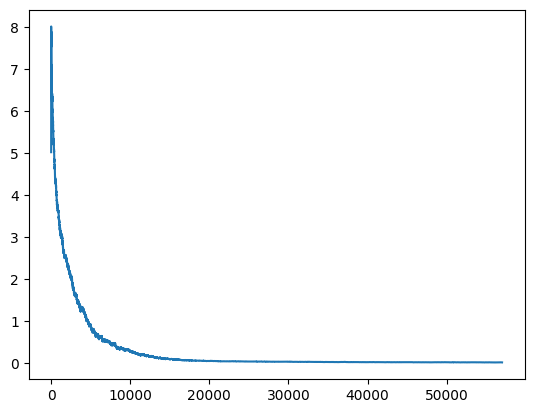

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["Ʉweri mari na'zanʉn nuse', miwiri zamʉ na'kawa ukumana gun nʉndi, ɉe na'ɉure, ɉe na'kawa ukumana gun nʉndi, nʉka'gʉmʉn pari a'chonʉkwa nʉkʉnise', miwiri miwikeynʉn nʉnhipana ukumana gun nʉndi."]
['Porque estuve hambriento, y ustedes me dieron de comer; estuve sediento, y me dieron de beber; llegué como un extraño, y me recibieron en sus casas;']
['Porque la paz de este pueblo está por encima de la promesa que Dios hizo a nuestros antepasados, y el día en que Lot salió de Sodoma, llovió del cielo fuego y azufre y acabó con todos.']


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x 2 americasnlp americasnlp 4.0K Mar  7 12:19 .
4.0K drwxrwxr-x 7 americasnlp americasnlp 4.0K Mar  7 11:59 ..
972K -rw-rw-r-- 1 americasnlp americasnlp 971K Mar  7 11:59 all_texts_file.csv
4.0K -rw-rw-r-- 1 americasnlp americasnlp  848 Mar  8 02:48 config.json
4.0K -rw-rw-r-- 1 americasnlp americasnlp  184 Mar  8 02:48 generation_config.json
5.2G -rw-rw-r-- 1 americasnlp americasnlp 5.2G Mar  8 02:48 pytorch_model.bin
4.8M -rw-rw-r-- 1 americasnlp americasnlp 4.8M Mar  8 02:48 sentencepiece.bpe.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp 3.5K Mar  8 02:48 special_tokens_map.json
376K -rw-rw-r-- 1 americasnlp americasnlp 373K Mar  7 11:59 spm_16k.model
148K -rw-rw-r-- 1 americasnlp americasnlp 148K Mar  7 11:59 spm_16k.vocab
4.8M -rw-rw-r-- 1 americasnlp americasnlp 4.8M Mar  7 11:59 spm_nllb_268k.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp  570 Mar  8 02:48 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

["kanuñey na'zuna ka' ku'ngunu re'gawiri, ayeygwi aguzanʉn nu'kwin na'zuneyka,"]


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

["kanuñey na'zana umungwi awun nugeyka kuyukin nari nʉnʉkeygwi kuyukin"]

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['muy satisfactorio también sentir la vitalidad de estos pueblos antiguos, emprendiendo nuevos caminos de entendimiento del mundo de hoy, que sean a la vez nuevos caminos de profundización de su memoria']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['muy interesados por esta traducción']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/579 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 7.72 28.4/7.9/4.7/3.3 (BP = 1.000 ratio = 1.037 hyp_len = 15603 ref_len = 15047)
chrF2++ = 24.17
BLEU = 8.29 29.7/10.4/5.2/3.1 (BP = 0.986 ratio = 0.986 hyp_len = 13825 ref_len = 14019)
chrF2++ = 32.98


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,arh,esp,arh_translated,esp_translated
1807,"Na'no'kwa zʉn awiri nʉkʉriwia awʉnki, nʉn kinkiri, anugwe rʉnrʉn na'nisiri, awʉnkawa na'zʉna nek...","¡Vengan a mí todos los que están cansados y agobiados, y yo les daré descanso!","""Miwiri inʉ winigunamʉsʉkwey awiri uzweykwey nanu' neyka ɉinase'ri nʉkeykuma ʉwin, ey unige'ri n...","He servido a Dios con toda humildad, en medio de las angustias y pruebas que me sobrevinieron a ..."
2932,"inʉri kʉriwiya ɉina eyki winʉwiukwa kawa'me, ey awi winʉmasʉya'bari: —“Ikʉ zʉ Gʉmʉsinʉ warinzanʉ...",porque estaba dedicado a instruir a sus discípulos. Les explicaba que el Hijo del hombre iba a s...,"Awi eykʉri ikʉ winʉwiya'bari: - ""Ikʉ zʉ gʉmʉsinʉ warin zanʉri ikʉse' ipʉnhákumey agwaka a'wnʉnni...",A continuación Jesús convocó a sus discípulos y les dijo: - El Hijo del hombre está a punto de s...
622,"Ʉweri, ɉwí ʉnniwekʉpana awaki nuga'me gun Kanaán pari eygwi ɉwí ʉnmekʉn gun ana'na nʉndi. ¿Azini...","Si vinimos desde Canaán a devolver el dinero que encontramos en la boca de nuestros costales, ¿p...","ɉwíri tína nákúyʉn, ɉwíri tína nákúyʉn,","Si no quiere escucharte, insiste llevando contigo todo lo que tiene. ¿Qué valor te parece, si no..."
2025,"Ey uye'ri saserdoti zʉ sakuku ɉinari, umʉnte wina'rizʉna ɉinasin winʉnkʉncho'sʉn keywʉ rizoriri,...","Estos se reunieron con los ancianos del pueblo, y entre todos acordaron sobornar a los soldados","Ey uye' nʉngwa soldadu ɉinari, umʉnte wina'zʉna ɉinasin winʉnni'kumana ɉinasin winʉnni'siri, yow...",Los jefes de los sacerdotes y los ancianos del pueblo tomaron el dinero e hicieron como se les h...
4578,"i'ngwiri masitesin keywʉ zoyanáɉuri, saserdoti zʉ sakuku ʉmʉn a'zʉna zʉ gunamʉ ná kukwʉ durigʉ...",Y uno de ellos dio un golpe al criado del sumo sacerdote y le cortó la oreja derecha.,Uye'ki i'ngwiri saserdoti ɉina zʉ sakuku umʉn a'zʉna zʉ gunamʉ kukwʉ kʉbeykí keywʉ nu'nari.,"Uno de los que estaban con él sacó la espada y, de un golpe, le cortó una oreja al criado del su..."
5686,"Nʉgʉmʉsinʉ ɉina, Kakʉ ɉwa'kuma awaki nuga'me miwise'ri miwika'siwin. Achʉná ɉina, kʉtʉkʉnʉn inʉ ...","Les escribo a ustedes, los mayores, porque conocen al que existe desde el principio. Les escribo...",Eyma ɉuna unikʉyari Kakʉ riguzʉnhasʉkwa kʉnanu' na'me'ri na'nʉnno.,"Hijos míos, estamos en la última hora, la hora del anticristo, según ya oyeron. Efectivamente, e..."
1128,Ey uye' nʉngwa Niwipaw Niwisakukuse'ri: —“¿Inʉ tikiriri nʉnʉniri mikey i'e? ¿Kwa kʉn mʉga gu' ná...,"Entonces Dios, el Señor, le preguntó:—¿Y quién te dijo que estabas desnudo? ¿Acaso has comido de...","Ey uye' nʉngwa Niwipaw Niwisakukuri: - ""¿Mari inʉ chʉka'ri tikirí nʉkawin me'zano? ¿Makuruma nʉn...",Entonces el Señor replicó: - ¿Cuántas veces he de estar entre ustedes? ¿Hasta cuándo tendré que ...
3459,"Jesuse' keywʉ winʉkey ie'ri: —“Báy eygwi ʉɉwʉn mʉchey zóya awʉndi, eymekʉ ayeygwi ga'kʉnamʉ zaka...","y, cuando lo encontraron, le dijeron:—Todos están buscándote.","winchwa keywʉ uye'ri: - ""Sakuku, ka'gʉmʉse'ri má nʉtakʉn nugin"" winʉkey ie' nʉngwa,",Jesús les dijo: - Vayan a las aldeas para que anuncien a todos el evangelio.
1859,"apawse'ri eymí zʉn nikʉn nuga ʉnchwʉndi gunamʉ mowga mowga niga, katigu kanʉyáy awi zʉndi katigu...",Entonces lo castigará severamente dándole un lugar entre los hipócritas. Allí llorará y le rechi...,"Ey unige'ri umʉngwi katigu a'sʉsʉngwa'sa awiri, mowga mowga aniga, na'ba winʉnka'mawʉn nu'nige'r...","Dos hombres estarán trabajando en el campo; a uno se lo llevarán y dejarán al otro]. Sí figura, ..."
2008,Awi nʉngwari i'ba Galilea meyna rizwein rinuse'ri Jesuse'ri:—“Ikʉ zʉ Gʉmʉsinʉri cheyrwa ɉinase' ...,Pero este género de demonios solo sale por medio de oración y ayuno]. omiten este versículo.Jesú...,"Ʉwe'ki anugwe gʉnsinna ɉina kinkiri Niwipawsin rimasayʉn nukʉn zʉn aga'sʉkwey neykari nanu'kinó""...","Cuando aún estaban hablando del Mesías, Jesús se apareció primero a ellos y les dijo: - Este es ..."
